In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from conditioningMaps import build_regression_problem
plt.style.use('ggplot')

In [2]:
rng = np.random.default_rng(104)

In [3]:
p = 2/3
sigma = 1
n=20000
k = 2
xi_1 = rng.gamma(p,1,(n,k))
xi_2 = rng.gamma(p,1,(n,k))
#eta = sigma * (xi_1 - xi_2)
eta = sigma * rng.standard_normal((n,k))

ydim = 2
X = np.array([[3,1],[1,2]])
noise_level = 1
y_samples = (eta@X.T + noise_level * rng.standard_normal((n,ydim)))


target = np.hstack([y_samples,eta])
reference_dist = sigma * (rng.gamma(p,1,(n,k)) - rng.gamma(p,1,(n,k)))

#reference = np.hstack([y_samples,reference_dist])
reference = sigma * rng.standard_normal((n,k))

#reference = reference_dist


In [4]:
reg_X,reg_y = build_regression_problem(
    reference,
    target,
    conditioning_eps = 1e-2,
    dim_shared = 2,
    solver = 'lp'
)


Building Cost Matrix


ValueError: shapes (20000,0) and (2,20000) not aligned: 0 (dim 1) != 2 (dim 0)

In [22]:
from sklearn.neighbors import KNeighborsRegressor

In [23]:
# KRR = KernelRidge(alpha=1e-3,kernel='rbf',gamma=0.1)
# KRR.fit(reg_X,reg_y-reg_X[:,2:])


In [24]:
model = KNeighborsRegressor(n_neighbors = 1,weights = 'distance')
model.fit(reg_X,reg_y-reg_X[:,2:])

KNeighborsRegressor(n_neighbors=1, weights='distance')

In [25]:
num_samples = 500000
y_observed = np.array([1,1])

reference_samples = sigma * (rng.gamma(p,1,(num_samples,k)) - rng.gamma(p,1,(num_samples,k)))
posterior_reference = np.hstack([
    np.vstack([y_observed]*num_samples),
    reference_samples
])

posterior_samples = model.predict(posterior_reference)+reference_samples
prior_samples = sigma * (rng.gamma(p,1,(num_samples,k)) - rng.gamma(p,1,(num_samples,k)))

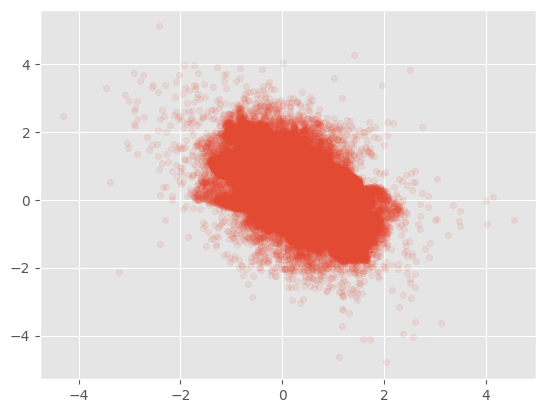

In [26]:
plt.scatter(posterior_samples[:,0],posterior_samples[:,1],s = 20,alpha =0.1)
#plt.scatter(prior_samples[:,0],prior_samples[:,1],s = 3,alpha =0.5)
# plt.xlim(-1,2)
# plt.ylim(-1,2)


In [69]:
reference.shape

(20000, 4)

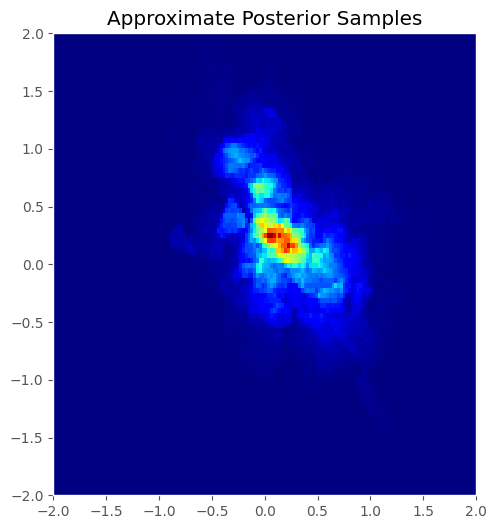

In [19]:
#filtered_posterior_samples = posterior_samples[np.max(np.abs(posterior_samples),axis=1)<1.5]
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Approximate Posterior Samples")
plt.hist2d(posterior_samples[:,0],posterior_samples[:,1],300,cmap=plt.cm.jet)
plt.xlim(-2,2)
plt.ylim(-2,2)
# plt.subplot(1,2,2)
# plt.title("Comparison with no likelihood term: True Prior")
# plt.hist2d(reference[:,2],reference[:,3],100,cmap=plt.cm.jet)
# plt.xlim(-5,5)
# plt.ylim(-5,5)
plt.show()


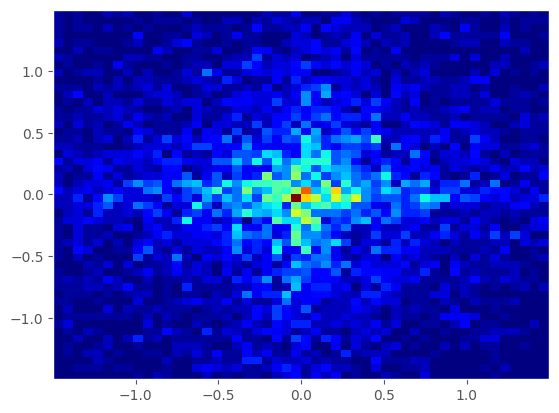

In [53]:
from seaborn import kdeplot
filtered_posterior_samples = posterior_samples[np.max(np.abs(posterior_samples),axis=1)<1.5]
# kdeplot(
#     x=filtered_posterior_samples[:,0],
#     y=filtered_posterior_samples[:,1],
#     fill=True,
#     bw_adjust=0.4
# )


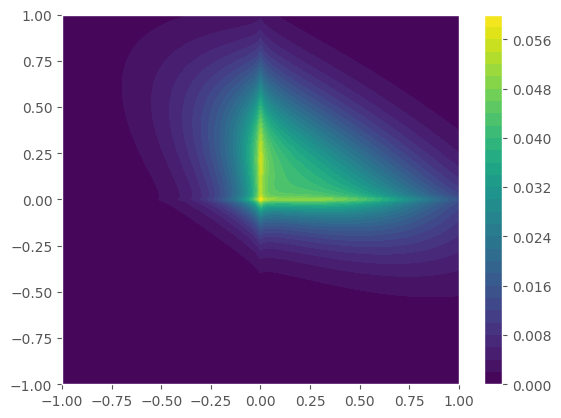

In [66]:
def get_BK(p,sigma):
    from scipy.special import gamma
    from scipy.special import kv
    def BK(t):
        renorm = 1/(np.sqrt(np.pi)*gamma(p)*(sigma**(p+(1/2))*(2**(p-1/2))))
        bessel_part = kv(p-(1/2),np.abs(t/sigma))
        return renorm * bessel_part * (np.abs(t)**(p-1/2))
    return BK
from scipy.stats import norm
bk = get_BK(p,sigma)
num_grid_points = 300
grid = np.linspace(-1,1,num_grid_points)

x0,x1 = np.meshgrid(grid,grid)

mesh = np.array([x0,x1])
mesh_points = mesh.T.reshape(-1,2)

loglik = np.sum(norm.logpdf(mesh_points@X-y_observed),axis=1)
prior_density = bk(mesh_points)
log_prior = np.sum(np.log(prior_density),axis=1)
posterior_log_density = loglik+log_prior
posterior_density = np.exp(posterior_log_density.reshape(num_grid_points,num_grid_points))
plt.contourf(x0,x1,posterior_density,30)
plt.colorbar()